# Running an MD simulation (currently with explicit solvent)

This code is largely taken from this wonderful tutorial series (https://github.com/molmod/openmm-tutorial-msbs/blob/main/07_ligands/ligands.py)

In [4]:
# Python built-in modules
from sys import stdout

# Popular scientific packages for Python
import matplotlib.pyplot as plt
import mdtraj

# MD related packages
import nglview
import numpy as np

# OpenFF package.
# Do not use from openff.xxx import ... to avoid name collisions.
import openff.toolkit.topology
import openff.toolkit.typing.engines.smirnoff
import openmmforcefields.generators

# Other utilities for setting up the
import openmoltools
import pandas
import requests

from openmm import *
from openmm.app import *
from openmm.unit import *

In [8]:
def convert_sdf_to_pdb(fn_sdf, fn_pdb, resname="UNL"):
    """Convert an SDF file (from PubChem, ChemDraw, ...) to a proper PDB file.

    Parameters
    ----------
    fn_sdf
        Path of the SDF file, must exist.
    fn_pdb
        Path of the PDB file. If it exists, it will be overwritten.
    resname
        The residue name in the PDB file. Maximum 3 characters.

    Notes
    -----
    Openbabel can also perform this type of conversion, but generally does a
    poor job on the atom names in the PDB file. This is a one-off
    implementation, not meant to be easily extendible to other formats etc. It
    will not handle broken SDF files gracefully either. All atoms are put in one
    residue and one chain.

    """
    if len(resname) > 3:
        raise ValueError("Residue name too long.")
    # Read the relevant SDF data.
    with open(fn_sdf) as f:
        # skip a few lines
        next(f)
        next(f)
        next(f)
        words = next(f).split()
        natom = int(words[0])
        nbond = int(words[1])
        # atomic positions in angstroms
        atcoords = np.zeros((natom, 3), float)
        atsymbols = []
        for iatom in range(natom):
            words = next(f).split()
            atcoords[iatom] = words[:3]
            atsymbols.append(words[3])
        # bonds with atom indexes starting at 1.
        # fomat of one row: [first atom, second atom, integer bond order]
        bonds = np.zeros((nbond, 3), int)
        for ibond in range(nbond):
            words = next(f).split()
            bonds[ibond] = words[:3]

    # Convert bonds to neighbour dictionary, needed for the CONECT lines in PDB.
    neighbors = {}
    for ia, ib, bo in bonds:
        neighbors.setdefault(ia, []).extend([ib] * bo)
        neighbors.setdefault(ib, []).extend([ia] * bo)

    # Write the PDB file
    hetatm_template = "".join(
        [
            "HETATM",
            "{:5d}",
            "{:>4s} ",
            " ",
            "{:<3s} ",
            "A",
            "   1",
            "    ",
            "{:8.3f}",
            "{:8.3f}",
            "{:8.3f}",
            "  0.00",
            "  0.00",
            "          ",
            "{:>2s}",
            "\n",
        ]
    )
    with open(fn_pdb, "w") as f:
        symbol_counters = {}
        for iatom, (atcoord, atsymbol) in enumerate(zip(atcoords, atsymbols)):
            c = symbol_counters.get(atsymbol, 0) + 1
            symbol_counters[atsymbol] = c
            atname = f"{atsymbol}{c}"
            f.write(
                hetatm_template.format(
                    iatom + 1,
                    atname,
                    resname,
                    atcoord[0],
                    atcoord[1],
                    atcoord[2],
                    atsymbol,
                )
            )
        for iatom, ineighs in sorted(neighbors.items()):
            f.write(
                "CONECT{:5d}{:s}\n".format(iatom, "".join(f"{ineigh:5d}" for ineigh in ineighs))
            )
        f.write("END\n")


def estimate_volume(fn_pdb):
    """Estimate an upper bound for the molecular volume, given a PDB file."""
    # Load Cartesian coordinates in Angstrom.
    traj_single = mdtraj.load(fn_pdb)
    xyz = traj_single.xyz[0] * 10
    # Get array with vdW radii
    vdw_radii = np.array([atom.element.radius for atom in traj_single.top.atoms]) * 10
    # Estimate the width in various directions and derive an average volume.
    nrep = 1000
    radii = np.zeros(nrep)
    for irep in range(nrep):
        unit = np.random.normal(0, 1, 3)
        unit /= np.linalg.norm(unit)
        tf = np.dot(xyz, unit)
        low = (tf - vdw_radii).min()
        high = (tf + vdw_radii).max()
        radii[irep] = (high - low) / 2
    # Compute average volume
    return ((4 / 3) * np.pi * radii**3).mean()

## 1. Download and convert molecules from PubChem

In [6]:
# Provide the PubChem compound IDs as strings:
cids = [
    "3672",  # ibuprofen
    "962",  # water
]
# Residue names to be used in the PDB files
resnames = [
    "IBU",
    "HOH",
]
# Number of times each molecule is added to the simulation cell.
num_molecules = [2, 500]

In [9]:
fns_sdf = []
fns_pdb = []
for cid, resname in zip(cids, resnames):
    # Download the SDF file if not present yet.
    fn_sdf = f"CID_{cid}.sdf"
    if not os.path.isfile(fn_sdf):
        url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/CID/{cid}/record/SDF/?record_type=3d&response_type=save"
        with open(fn_sdf, "w") as f:
            f.write(requests.get(url).text)
    fn_pdb = f"CID_{cid}.pdb"
    convert_sdf_to_pdb(fn_sdf, fn_pdb, resname)
    fns_sdf.append(fn_sdf)
    fns_pdb.append(fn_pdb)

## 2. Build the explicit solvent model with packmol

Packmol is a tool to place molecules at random positions into a simulation cell, without any overlap. We use it here to generate random mixtures, but it can also be used for more advanced setups. See http://m3g.iqm.unicamp.br/packmol/home.shtml

In [10]:
# approximate volumes of solute and solvent, needed to estimate the initial box size.
volumes = [estimate_volume(fn_pdb) for fn_pdb in fns_pdb]
print("Volumes [Å^3]:", volumes)
total_volume = np.dot(volumes, num_molecules)
box_size = total_volume ** (1.0 / 3.0)
print("Box size [Å]:", box_size)

# Run packmol through the openmoltools wrapper.
print("--- Packmol input ---")
traj_packmol = openmoltools.packmol.pack_box(fns_pdb, num_molecules, box_size=box_size)
traj_packmol.save_pdb("packmol_02.pdb")

Volumes [Å^3]: [493.7299817616684, 22.010758964828202]
Box size [Å]: 22.889730173768335
--- Packmol input ---

# Mixture

tolerance 2.000000
filetype pdb
output /tmp/tmpnnqqmkm4/tmpfn0o6f65.pdb
add_amber_ter


structure CID_3672.pdb
  number 2
  inside box 0. 0. 0. 20.889730 20.889730 20.889730
end structure

structure CID_962.pdb
  number 500
  inside box 0. 0. 0. 20.889730 20.889730 20.889730
end structure


################################################################################

 PACKMOL - Packing optimization for the automated generation of
 starting configurations for molecular dynamics simulations.
 
                                                              Version 18.013 

################################################################################

  Packmol must be run with: packmol < inputfile.inp 

  Userguide at: www.ime.unicamp.br/~martinez/packmol 

  Reading input file... (Control-C aborts)
  Will add the TER flag between molecules. 
  Seed for random nu

As you can see in the visualization of the initial structure below, the simulation cell contains a vacuum edge, which is due to a limitation of packmol. This is not a problem since the system will be equilibrated with NpT molecular dynamics, which will gradually adjust the cell size.

In [11]:
# Visualize the initial solvated system
traj_init = mdtraj.load("packmol_02.pdb")
view = nglview.show_mdtraj(traj_init)
view.clear_representations()
view.add_licorice()
view.add_unitcell()
view

NGLWidget()

## 3. Assign Sage parameters with the SMIRNOFF engine

In this section, the force field parameters are assigned using the methodology developed in the OpenFF community.
The SDF files are used as input because they contain bond-order data, which are needed to assign the correct parameters.

In [12]:
# The generator can create an OpenMM system object.
# It uses standard force fields when applicable and
# falls back to OpenFF when needed.
generator = openmmforcefields.generators.SystemGenerator(
    ["tip3p.xml"],
    small_molecule_forcefield="openff-2.0.0",
    molecules=[openff.toolkit.topology.Molecule.from_file(fn_sdf) for fn_sdf in fns_sdf],
)
# Create the OpenMM system using the output of packmol.
pdb = PDBFile("packmol_02.pdb")
system = generator.create_system(pdb.topology)

The following line prints the non-bonding parameters of the last atom, which you can use to check if the right parameters were loaded for the last atom.

For example, when running this notebook without modifications, the molecule is water and the last atom is a hydrogen. You should observe the charge of the hydrogen atom in tip3p-fb, which you can compare to the parameter from the XML parameter file: https://github.com/openmm/openmm/blob/master/wrappers/python/openmm/app/data/amber14/tip3pfb.xml#L249

In [13]:
for force in system.getForces():
    if isinstance(force, openmm.NonbondedForce):
        npart = force.getNumParticles()
        print(force.getParticleParameters(npart - 1))

[Quantity(value=0.417, unit=elementary charge), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]


## 4. Short NpT molecular dynamics simulation

In [14]:
# Setup the MD
temperature = 300 * kelvin
pressure = 1 * bar
integrator = LangevinIntegrator(temperature, 1 / picosecond, 2 * femtoseconds)
system.addForce(MonteCarloBarostat(pressure, temperature))
simulation = Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.positions)
simulation.minimizeEnergy()

# Write the initial state back to a PDB, could be useful
# for debugging.
with open("init_02.pdb", "w") as f:
    PDBFile.writeFile(simulation.topology, pdb.positions, f)

# Set the reporters collecting the MD output.
simulation.reporters = []
simulation.reporters.append(DCDReporter("traj_02.dcd", 100))
simulation.reporters.append(
    StateDataReporter(stdout, 1000, step=True, temperature=True, elapsedTime=True)
)
simulation.reporters.append(
    StateDataReporter(
        "scalars_02.csv",
        100,
        time=True,
        potentialEnergy=True,
        totalEnergy=True,
        temperature=True,
        volume=True,
    )
)
simulation.step(10000)

# The last line is only needed for Windows users,
# to close the DCD file before it can be opened by nglview.
del simulation

#"Step","Temperature (K)","Elapsed Time (s)"
1000,271.80388299062264,8.535385131835938e-05
2000,273.27378941813424,1.827427625656128
3000,303.643176801582,3.7404673099517822
4000,288.33035271679995,5.568492412567139
5000,302.50212002996295,7.377182960510254
6000,290.60565564531225,9.194826602935791
7000,288.92379901367843,11.092984676361084
8000,301.9614678278609,12.886671781539917
9000,309.60412941770346,14.72817349433899
10000,308.894970078197,16.634505033493042


In [15]:
# Visualize the trajectory.
view = nglview.show_mdtraj(mdtraj.load("traj_02.dcd", top="init_02.pdb"))
view.clear_representations()
view.add_licorice()
view.add_unitcell()
view

NGLWidget(max_frame=99)

<Axes: xlabel='#"Time (ps)"'>

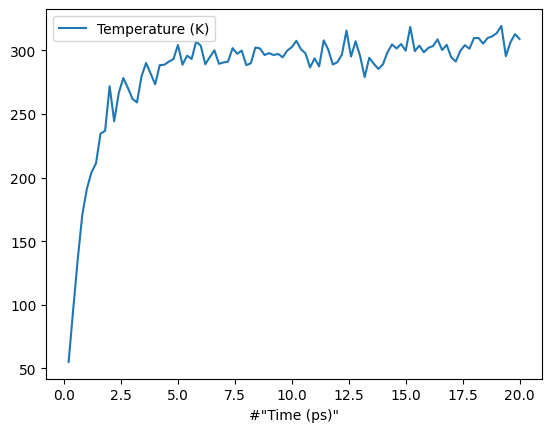

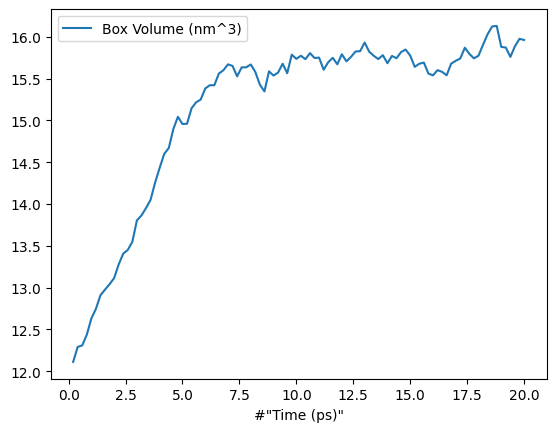

In [16]:
# Plot temperature and volume as an initial verification of convergence.
df = pandas.read_csv("scalars_02.csv")
df.plot(kind="line", x='#"Time (ps)"', y="Temperature (K)")
df.plot(kind="line", x='#"Time (ps)"', y="Box Volume (nm^3)")

## 5. Changing compositions

**<span style="color:#A03;font-size:14pt">
&#x270B; HANDS-ON! &#x1F528;
</span>**

> Try a few different compositions of the simulation cell (i) to verify that you can include practically any molecule you like and (ii) to see how the cost of setting up the force field can vary:
>
> - Remove the ibuprofen molecules.
> - Replace the second ibuprofen by another drug molecule (e.g. aspirin).
> - Replace the two ibuprofens by one large drug molecule (e.g. amoxicillin).
> - Replace the solvent (e.g. dimethylether).